## Introduction to DistKP
This notebook provides a minimal implementation of DistKP.

We consider $n$ agents. 
For the sake of simplicity, we use as domain a unit hyperrectangle $\mathcal{P} = [0,1]^{s}$.

The algorithm has two tunable parameters:
1. &nbsp;$E$: &nbsp;&nbsp;&nbsp; the order of the Nystrom approximation. A higher value yelds more precision at the cost of increased memory and computation.
2. &nbsp;$\sigma_w$: &nbsp;&nbsp; encodes our prioir knowledge of how fast the function changes with time.

At intialization the algorithm samples $E$ representative points (the seed guarantees that the same points are used by every agent) and computes the matrices $\Lambda$ and $U_{11}$ that are going to be used to compute the features.
<br>
<br>
During online operations the agent:
1. Collects a noisy sample of the function. <br><br>
2. Performs a local update step with a standard Kalman Filter.<br><br>
3. Performs $SensingPeriod$ times:  <br><br>
    3.1. Communicates the quantities $L = P^{-1} \theta$, $\widetilde{P} = P^{-1}$ to the neighbours.   <br><br>
    3.2. Updates the local measures with the incoming information by applying a modified inverse variance weighting step.   
</par>

In [4]:
import numpy as np
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, FloatSlider

sigma_init = 10

class Agent:
    sigma_init = 1e5
    def __init__(self, s, E, k, sigma_v, sigma_w, n, init_pos, seed=42):
        self.E = E
        self.n = n
        self.s = s
        self.k = k
        self.R = sigma_v**2 * np.eye(1)
        self.Q = sigma_w**2 * np.eye(self.E)
        self.pos = init_pos

        # Estimate initialization
        self.theta = np.zeros((E,1))
        self.P = sigma_init**2 * np.eye(E)

        # Compute representative points
        np.random.seed(seed)
        self.repr_points = np.zeros((E,self.s))
        for i in range(self.s):
            self.repr_points[:,i] = np.random.uniform(low=0.0, high=1.0, size=(E))

        K = self.k(self.repr_points, self.repr_points)
        self.U_11, self.Lambda, _ = np.linalg.svd(K)

    def extract_features(self, x):
        if x.ndim < 2:
            x = x[np.newaxis,:]
        phi = np.linalg.inv(np.diag(self.Lambda))**0.5 @ self.U_11.T @ self.k(self.repr_points, x)
        return phi
        
    def local_update(self, x, y):
        # Projects domain point onto feature space
        phi = self.extract_features(x)

        # Kalman Filter
        # Prediction
        self.theta = self.theta
        self.P = self.P + self.Q

        # Correction
        self.theta = self.theta + self.P @ phi @ np.linalg.solve(phi.T @ self.P @ phi + self.R, y - phi.T @ self.theta)
        self.P = (np.eye(self.E) - self.P @ phi @ np.linalg.solve(phi.T @ self.P @ phi + self.R, phi.T)) @ self.P

    def communicate(self):
        # Implements communication with neighbours
        L = np.linalg.solve(self.P, self.theta)
        P_tilde = np.linalg.inv(self.P)
        return L, P_tilde

    def update_pos(self, pos):
        self.pos = pos

    def network_update(self, neighbours):
        # Implements distributed estimate fusion
        sum_L = np.zeros_like(self.theta)
        sum_P_tilde = np.zeros_like(self.P)
        for neighbour in neighbours:
            L, P_tilde = neighbour.communicate()
            sum_L += L
            sum_P_tilde += P_tilde

        L = sum_L/len(neighbours)
        P_tilde = sum_P_tilde/len(neighbours)
        
        self.theta = np.linalg.solve(P_tilde, L)
        self.P = np.linalg.inv(P_tilde)

    def predict(self, x):
        # Predict mean and variance at coordinate x
        phi = self.extract_features(x)
        mean = self.theta.T @ phi
        var = np.diag(phi.T @ self.P @ phi)

        return mean, var


### Simulation setup
We showcase the algorithm on a simple synthetic function, using a swarm of 10 drones. The drones perform a random walk in the domain with clipped gaussian steps.

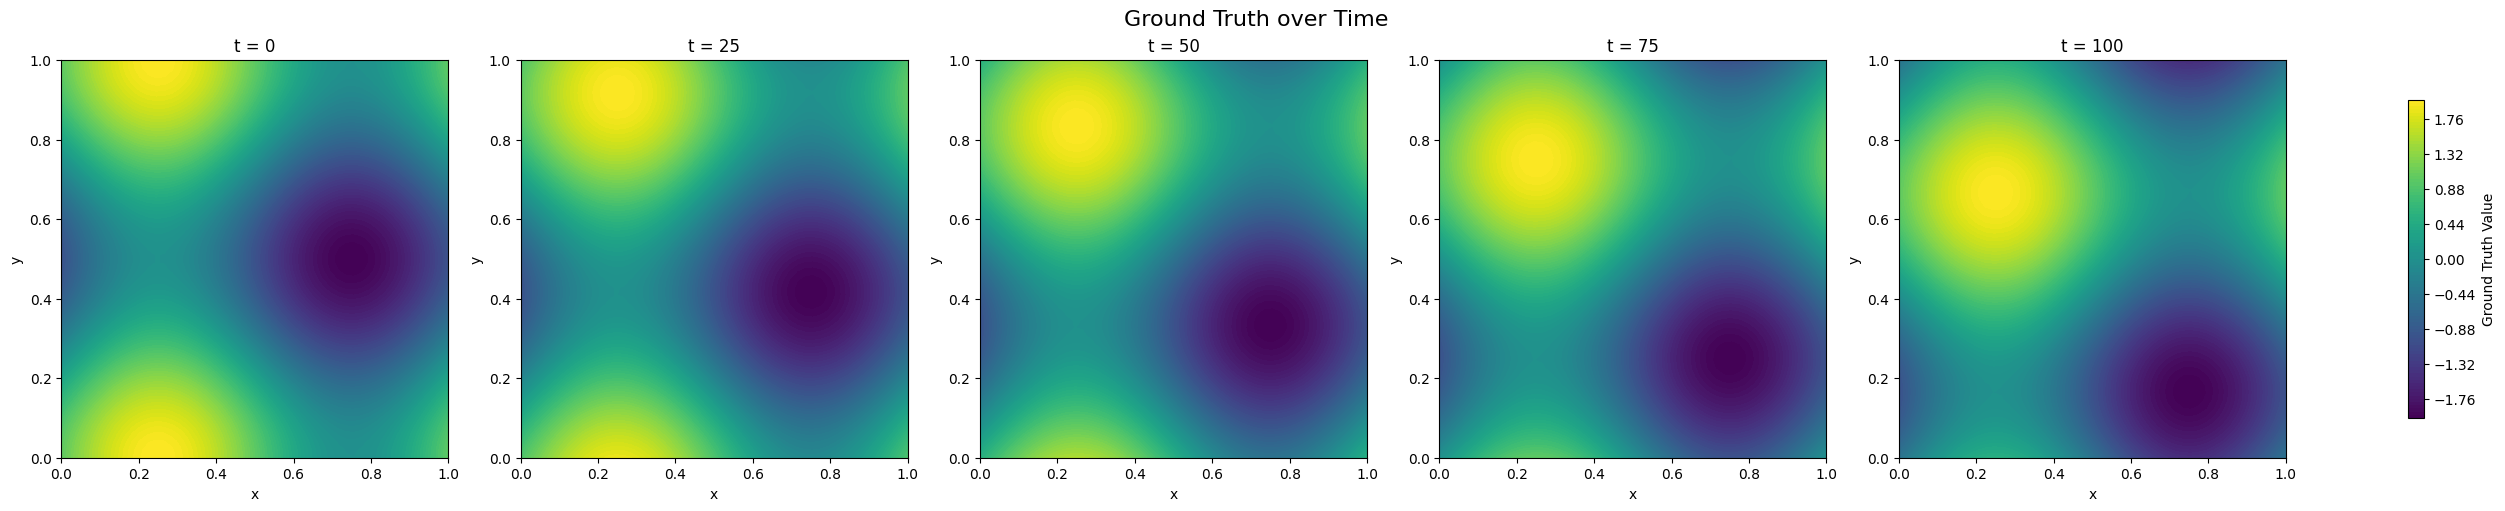

In [5]:
omega = 2*np.pi/1
v = 2*np.pi/300

ground_truth = lambda pos, t: np.sin(omega*pos[0]) + np.cos(omega*pos[1] + v*t)

# Create 50x50 uniform grid in [0,1] x [0,1]
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)
# Flatten the grid to a list of positions: shape (2500, 2)
positions = np.stack([X.ravel(), Y.ravel()], axis=1)
t_values = [0, 25, 50, 75, 100]

# Create subplots: 1 row, 5 columns
fig, axes = plt.subplots(1, len(t_values), figsize=(25, 5), constrained_layout=True)

for ax, t in zip(axes, t_values):
    Z = ground_truth((X, Y), t)
    contour = ax.contourf(X, Y, Z, levels=100)
    ax.set_title(f"t = {t}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

# Add one colorbar for all subplots
fig.colorbar(contour, ax=axes.ravel().tolist(), shrink=0.8, label="Ground Truth Value")

plt.suptitle("Ground Truth over Time", fontsize=16)
plt.show()

## Interactive Simulation Instructions

You can adjust the two parameters below to explore their effect on the simulation:

* **$E$** — the order of the approximation (choose from predefined discrete values)

* **sigma_w** ($\sigma_w$) — the process noise (adjustable via a slider)

After selecting the desired values, click the **"Run Simulation"** button to launch a new simulation. <br>
Please note that **higher values of $E$ may result in longer computation times**, so you may need to be patient while the results are being generated.

In [6]:
from ipywidgets import Dropdown, FloatSlider, Button, VBox, HBox, Output, Layout
from IPython.display import display
from IPython.display import HTML

display(HTML("<style>.widget-label { font-size: 25px; }</style>"))


SEED = 0

n = 10
num_steps=100
SensingPeriod=10
plot_freq=10
d = 1.0

# --- UI Widgets ---
E_dropdown = Dropdown(
    options=[10, 50, 150, 300],
    value=50,
    description='E',
    style={'description_width': 'initial'},
    layout=Layout(width='100px', height='40px', margin='10px 50px 10px 0')
)
sigma_slider = FloatSlider(
    value=0.5,
    min=0.01,
    max=1.0,
    step=0.01,
    description='sigma_w',
    style={'description_width': 'initial'},
    layout=Layout(width='500px', height='40px', margin='10px 50px 10px 0')
)
run_button = Button(
    description="Run Simulation",
    button_style='success',
    layout=Layout(width='150px', height='40px', margin='10px 0 10px 10px')
)
output = Output()

# --- Simulation Function ---
def run_simulation(E, sigma_w):
    np.random.seed(SEED)

    drones = [
        Agent(
            s=2,
            E=E,
            k=ConstantKernel(1e-2, constant_value_bounds="fixed") * RBF(1, length_scale_bounds="fixed"),
            sigma_v=1e-3,
            sigma_w=sigma_w,
            n=n,
            init_pos=np.random.uniform(low=0.0, high=1.0, size=(2)),
            seed=SEED
        ) for _ in range(n)
    ]

    for step in range(num_steps+1):
        # Move each drone
        for drone in drones:
            delta_pos = np.random.normal(loc=0.0, scale=0.1, size=(2))
            new_pos = np.clip(drone.pos + delta_pos, 0, 1)
            drone.update_pos(new_pos)

        # Local update
        for drone in drones:
            y = ground_truth(drone.pos, step)
            drone.local_update(drone.pos, y)

        # Network update
        for _ in range(SensingPeriod):
            for drone in drones:
                neighbours = [
                    drone2 for drone2 in drones
                    if np.linalg.norm(drone.pos - drone2.pos) < d
                ]
                drone.network_update(neighbours)

        # Plot
        if step % plot_freq == 0:
            Z_true = ground_truth((X, Y), step)
            Z_mean = np.zeros_like(X)
            Z_var = np.zeros_like(X)

            for i, pos in enumerate(positions):
                mean, var = drones[0].predict(pos)
                Z_mean.ravel()[i] = mean
                Z_var.ravel()[i] = var

            drone_x = [drone.pos[0] for drone in drones]
            drone_y = [drone.pos[1] for drone in drones]

            with output:
                fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

                im0 = axs[0].contourf(X, Y, Z_true, levels=100)
                axs[0].plot(drone_x, drone_y, 'ro')
                axs[0].set_title('Ground Truth')
                fig.colorbar(im0, ax=axs[0])

                im1 = axs[1].contourf(X, Y, Z_mean, levels=100)
                axs[1].plot(drone_x, drone_y, 'ro')
                axs[1].set_title("Mean")
                fig.colorbar(im1, ax=axs[1])

                im2 = axs[2].contourf(X, Y, Z_var, levels=100)
                axs[2].plot(drone_x, drone_y, 'ro')
                axs[2].set_title("Variance")
                fig.colorbar(im2, ax=axs[2])

                plt.suptitle(f"Step {step} (E={E}, sigma_w={sigma_w:.2e})", fontsize=16)
                plt.show()

# --- Button Callback ---
def on_run_button_click(b):
    output.clear_output()
    run_simulation(E_dropdown.value, sigma_slider.value)

run_button.on_click(on_run_button_click)

# --- Display UI ---
ui = VBox([HBox([E_dropdown, sigma_slider, run_button]), output])
display(ui)

# Run once with defaults
run_simulation(E_dropdown.value, sigma_slider.value)

/tmp/ipykernel_6233/1213715041.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z_mean.ravel()[i] = mean
/tmp/ipykernel_6233/1213715041.py:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z_var.ravel()[i] = var
